In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from neuroginius.atlas import Atlas

from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from nilearn import plotting
import nibabel as nib

from bold_dementia.utils.configuration import get_config
from bold_dementia.cogpred import MatrixMasker, make_training_data, plot_haufe_pattern, plot_matrix
from bold_dementia.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
# Whole brain study
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
SUFFIX = "prediction" # suffix given to the matrix dir
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

## Prediction

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None, suffix=SUFFIX, ses="M000")
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


## Model from confounds

In [26]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing as prep
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier

ct = make_column_transformer(
    (prep.PolynomialFeatures(), ["current_scan_age"]),
    ("passthrough", ["current_scan_age"]),
    (prep.OneHotEncoder(), ["SEX"]),
    remainder="drop"
)
pipe = make_pipeline(
    ct,
    prep.StandardScaler(),
    LogisticRegression(),
)

outer_cv = GroupKFold(n_splits=8)

confound_scores = cross_val_score(
    pipe,
    metadata,
    metadata.cluster_label.values.astype(int),
    cv=outer_cv,
    groups=metadata.CEN_ANOM.values,
    scoring=make_scorer(f1_score, average="macro")
)
confound_scores

array([0.32098765, 0.27777778, 0.28374656, 0.30003935, 0.28494624,
       0.28099174, 0.25550661, 0.29100529])

In [27]:
from sklearn.linear_model import LinearRegression
def deconfound_vectors(vector, confounds):
    model = LinearRegression.fit(confounds, vector)
    return vector - model.predict(confounds)
    

## Model from FC

In [28]:
from bold_dementia.cogpred import MatrixMasker

res = MatrixMasker(REFNET, INTER).fit(matrices)
res.transform(matrices)

array([[-0.03327788, -0.03506452, -0.11767311, ..., -0.04719106,
        -0.01651634, -0.00755783],
       [ 0.06806289,  0.10569751, -0.04798594, ..., -0.01044436,
        -0.00880127,  0.10389543],
       [ 0.05906445, -0.04652063,  0.14125931, ..., -0.05546748,
        -0.07488239, -0.02516112],
       ...,
       [-0.02023878, -0.0011757 ,  0.05845929, ..., -0.14911   ,
         0.07251822, -0.00885314],
       [-0.04136877,  0.11294992, -0.03141229, ...,  0.1454019 ,
         0.01841054,  0.00744615],
       [-0.08445187,  0.02518038,  0.03651023, ..., -0.03240203,
        -0.02150305, -0.08746064]], dtype=float32)

In [29]:
from sklearn.linear_model import LinearRegression
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec, vec_to_sym_matrix
from sklearn.base import TransformerMixin, BaseEstimator, OneToOneFeatureMixin

class MatrixDeconfounder(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, confounds, y):
        assert y is not None
        vectors = sym_matrix_to_vec(y)
        self.model_ = self.model.fit(confounds, vectors)
        return self

    def transform(self, confounds, y=None):
        assert y is not None
        vectors = sym_matrix_to_vec(y)
        deconfounded_vectors = vectors - self.model_.predict(confounds)
        return vec_to_sym_matrix(deconfounded_vectors)
        

In [30]:
from bold_dementia.cogpred import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from nilearn.connectome import vec_to_sym_matrix
from bold_dementia.cogpred import compute_mat_size

net = SGDClassifier(
        loss="log_loss",
        penalty="l1",
        max_iter=3000,
        random_state=2024,
    )

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)
deconfounder = MatrixDeconfounder()
confounds = ct.fit_transform(metadata)

cats = ("stable", "slow decline", "steep decline")

test_scores, cm, patterns = run_cv(deconfounder, clf, matrices, metadata, confounds, outer_cv)

masker = clf.named_steps["matrixmasker"]
l = len(masker.vec_idx_)
n_regions = compute_mat_size(l)
hmat = vec_to_sym_matrix(
    patterns.transpose((0, 2, 1)), diagonal=np.zeros((outer_cv.n_splits, k, n_regions))
)

              precision    recall  f1-score   support

           0       0.93      0.71      0.80       221
           1       0.04      0.14      0.07        14
           2       0.00      0.00      0.00         3

    accuracy                           0.66       238
   macro avg       0.32      0.28      0.29       238
weighted avg       0.86      0.66      0.75       238

              precision    recall  f1-score   support

           0       0.80      0.47      0.59       101
           1       0.19      0.61      0.29        23
           2       0.33      0.19      0.24        16

    accuracy                           0.46       140
   macro avg       0.44      0.42      0.37       140
weighted avg       0.64      0.46      0.50       140

              precision    recall  f1-score   support

           0       0.86      0.48      0.61       103
           1       0.28      0.56      0.37        25
           2       0.16      0.45      0.23        11

    accuracy        

[Text(0, 0, '64')]

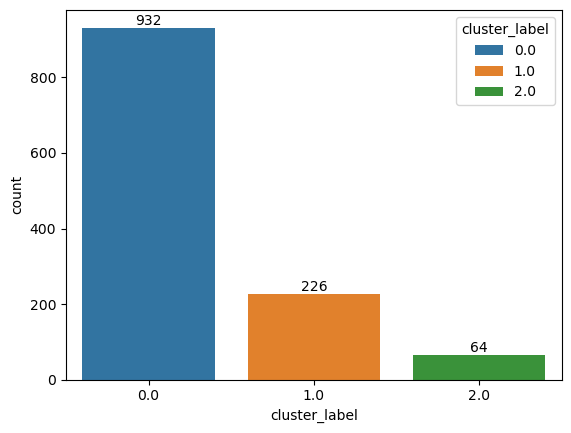

In [31]:
g = sns.countplot(metadata, x="cluster_label", hue="cluster_label", palette="tab10")
g.bar_label(g.containers[0])
g.bar_label(g.containers[1])
g.bar_label(g.containers[2])

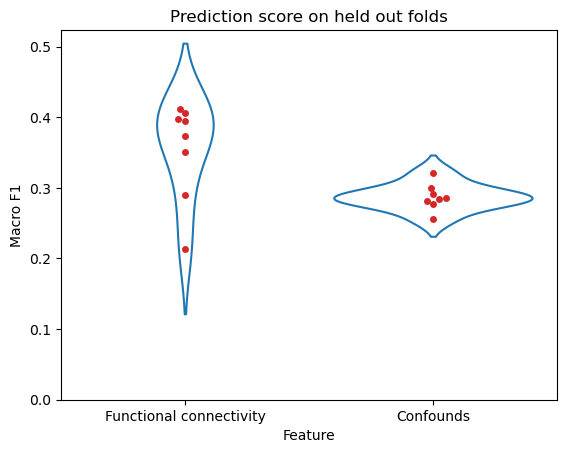

In [32]:
df = pd.DataFrame(np.stack([test_scores, confound_scores]).T, columns=["Functional connectivity", "Confounds"])
m = df.melt(var_name="Feature", value_name="Macro F1")
sns.swarmplot(m, x="Feature", y="Macro F1", color="tab:red")
sns.violinplot(m, x="Feature", y="Macro F1", color="tab:blue", fill=None, inner=None)
plt.ylim(0)
plt.title("Prediction score on held out folds")
plt.show()

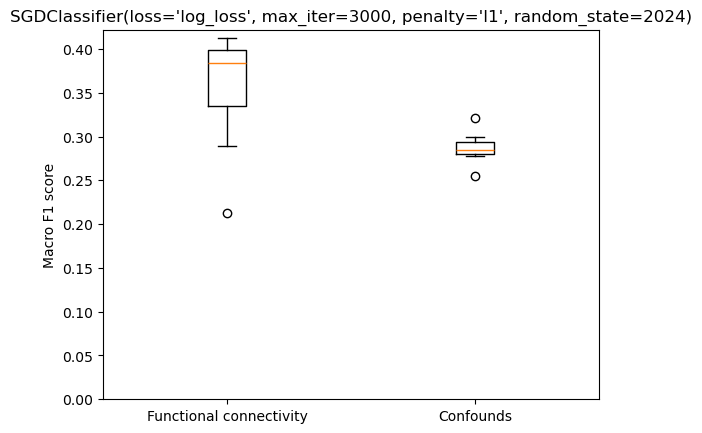

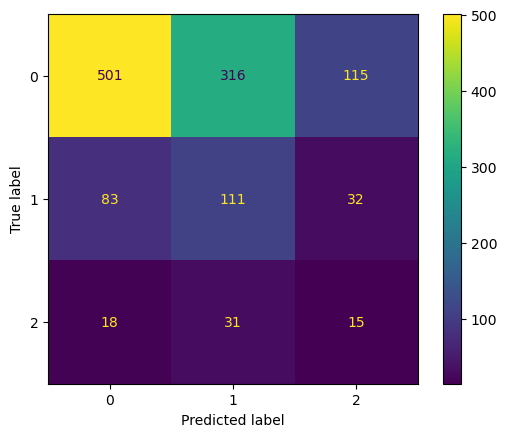

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot([test_scores, confound_scores])
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.ylabel("Macro F1 score")
plt.xticks(range(1, 3), ["Functional connectivity", "Confounds"])
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

In [34]:
np.mean(test_scores)

np.float64(0.35453458589111)

In [35]:
pd.DataFrame(test_scores).to_csv(run_path / "pred_scores.csv")

In [36]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


# Test significant score

/tmp/ipykernel_2050818/711523915.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(disp_sample, labels=labels)


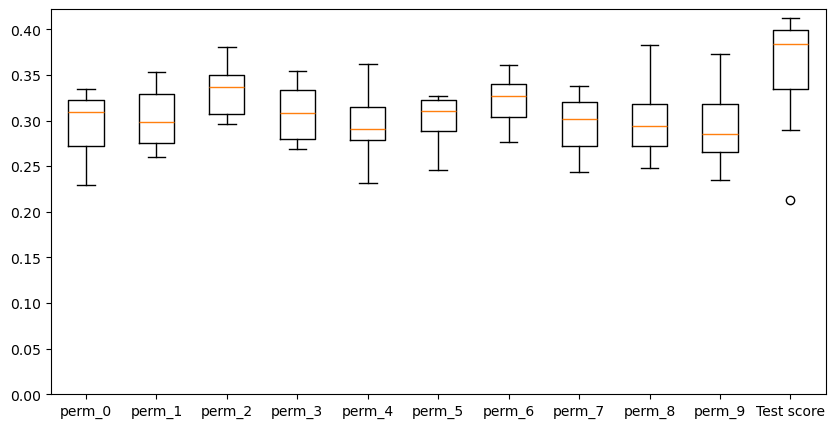

In [37]:
import random

N = 5000
#p = Path("/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-schaefer200_net-Default_inter-Default")
p = run_path
perm_res = joblib.load(p / f"{N}_permutations_res.joblib")
permscores = [pr[0] for pr in perm_res]
permweights = [pr[1] for pr in perm_res]

disp_sample = random.sample(permscores, k=10)
disp_sample.append(test_scores)

labels = [f"perm_{i}" for i in range(10)]
labels.append("Test score")

plt.subplots(figsize=(10, 5))
plt.boxplot(disp_sample, labels=labels)
plt.ylim(0)
plt.show()

median_scores = tuple(map(np.median, permscores))
median_test = np.median(test_scores)
pvalue = (np.sum(median_test < median_scores)+ 1) / (N + 1)

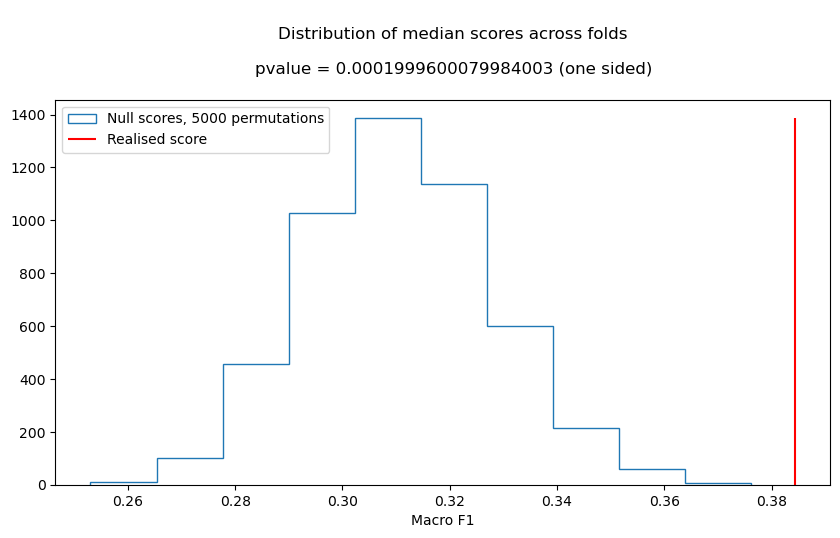

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
h = ax.hist(median_scores, histtype="step", label=f"Null scores, {N} permutations")
ax.vlines(median_test, ymin=0, ymax=np.max(h[0]), color="red", label="Realised score")
ax.set_title(
    f"""
    Distribution of median scores across folds\n
    pvalue = {pvalue} (one sided)
    """
)
ax.legend(loc="upper left")
ax.set_xlabel("Macro F1")
plt.show()

# Multiple comparisons adjustement

## Perms + FDR control

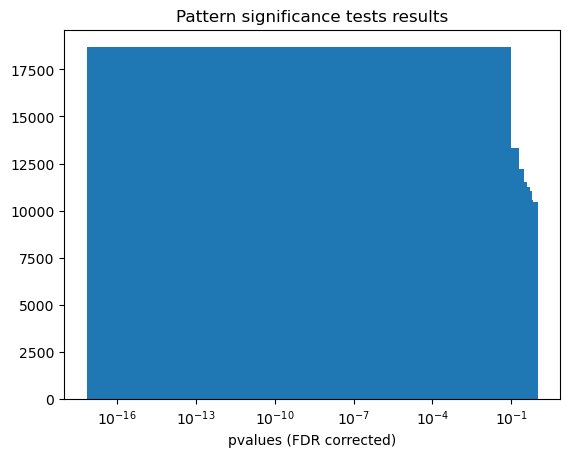

In [39]:
from nilearn.connectome import vec_to_sym_matrix
from statsmodels.stats.multitest import fdrcorrection
n_regions = int(np.sqrt(masker.topology_.sum()))

mean_perm_patterns = np.stack(permweights, axis=0).mean(axis=1)
mean_patterns = np.mean(patterns, axis=0)

pvalues_more = (np.sum(mean_patterns > mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues_less = (np.sum(mean_patterns < mean_perm_patterns, axis=0) + 1) / (N + 1)
pvalues = np.minimum(pvalues_less, pvalues_more) * 2

pvalues_corr = []
for class_idx in range(k):
    pvalues_corr.append(fdrcorrection(
        pvalues[:, class_idx]
    )[1])
pvalues_corr = np.stack(pvalues_corr, axis=1)
pvalues_corr = vec_to_sym_matrix(
        pvalues.transpose((1, 0)), diagonal=np.zeros((k, n_regions))
)
plt.hist(pvalues_corr.flatten())
plt.xscale("log")
plt.xlabel("pvalues (FDR corrected)")
plt.title("Pattern significance tests results")
plt.show()

In [40]:
# Map thresholded model weights from tangent to correlation space.
# A scaling factor is applied to avoid numerical errors,
# since projection implies matrix exponential which
# can output very high values.
conn_measure = joblib.load(f"{conn_dir}/atlas-{atlas.name}_{SUFFIX}/connectivity_measure.joblib")
thresh_map_tangent = np.where(pvalues_corr < (0.05), hmat, 0).mean(axis=0)
thresh_map = conn_measure.inverse_transform(thresh_map_tangent / 1e4)

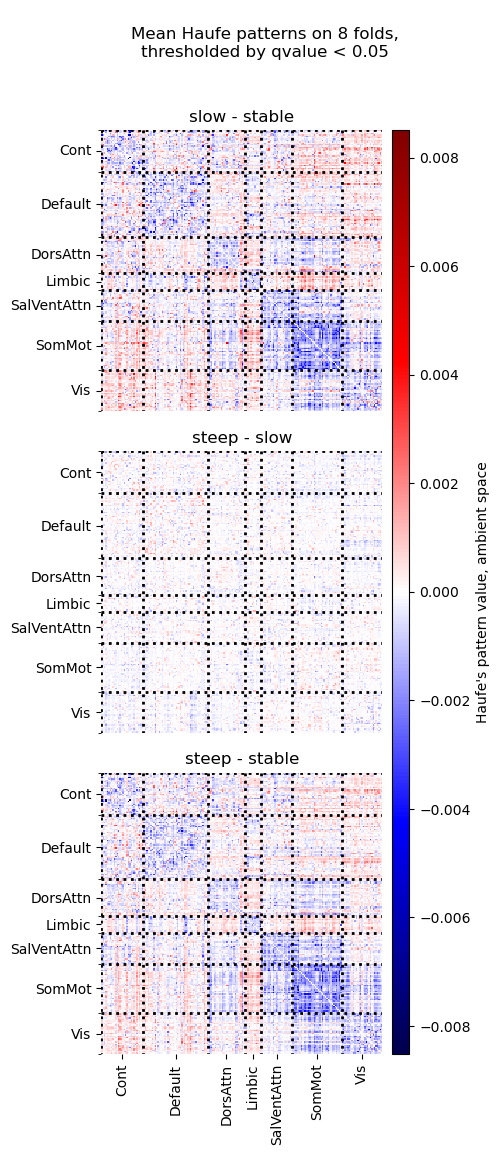

In [41]:
diffmaps = np.zeros((k, *matrices.shape[1:]))
stable_patterns = thresh_map[0, ...]
slow_patterns = thresh_map[1, ...]
steep_patterns = thresh_map[2, ...]

diffmaps[0, ...] = slow_patterns - stable_patterns
diffmaps[1, ...] = steep_patterns - slow_patterns
diffmaps[2, ...] = steep_patterns - stable_patterns

diffnames = ("slow - stable", "steep - slow", "steep - stable")
fig = plot_haufe_pattern(diffmaps, disp_atlas, diffnames)
fig.suptitle(
        f"""
        Mean Haufe patterns on {len(hmat)} folds,
        thresholded by qvalue < 0.05
        """)
plt.show()


In [42]:
joblib.dump(thresh_map_tangent[2], run_path / "haufe_steep.joblib")
joblib.dump(thresh_map_tangent[1], run_path / "haufe_slow.joblib")
joblib.dump(thresh_map_tangent[0], run_path / "haufe_stable.joblib")

['output/prediction/k-3_feat-fc_atlas-schaefer200_net-all/haufe_stable.joblib']

In [43]:
from bold_dementia.cogpred import plot_network, net_to_brain
from matplotlib.backends.backend_pdf import PdfPages

bounds = (-0.005, 0.005)

with PdfPages("output/zooms_.pdf") as pages:
    for net in np.unique(atlas.macro_labels):
        coords = None
        for i in range(3):

            diffmap = (thresh_map[(i+1) % 3, ...] - thresh_map[i, ...])

            fig, axes = plt.subplots(2, 1, figsize=(8, 12))
            fig.suptitle(f"{cats[(i+1) % 3]} - {cats[i]}")
            axes[0].set_title(net)
            axes[1].set_title("Sum of edges")
            
            plot_network(diffmap, atlas, net, cmap="seismic", bounds=bounds, ax=axes[0], cbar_kws={'label': 'Haufe pattern'})
            img = net_to_brain(diffmap, atlas, net)
            disp = plotting.plot_stat_map(img, cmap="seismic", vmin=bounds[0], vmax=bounds[1], cut_coords=coords, axes=axes[1], colorbar=False)
            coords = disp.cut_coords
            pages.savefig()
            plt.close()

### Compute ICC

In [44]:
import pingouin
from pingouin import intraclass_corr

pingouin.options['round'] = 5

data = sym_matrix_to_vec(hmat, discard_diagonal=True)

region_idx = tuple(range(data.shape[2])) * data.shape[1]
region_idx = list(map(str, region_idx))
frames = []
for i, ratings in enumerate(data):
    frame = pd.DataFrame(ratings.T, columns=cats)
    frame["model"] = f"model_{i}"
    frame = frame.melt(id_vars="model", var_name="cognitive_trajectory")
    frame["cognitive_trajectory"] = frame["cognitive_trajectory"] + region_idx
    frames.append(frame)

In [45]:
long_rating = pd.concat(frames)
res = intraclass_corr(long_rating, targets="cognitive_trajectory", raters="model", ratings="value")
res

(    Type              Description      ICC         F    df1     df2  pval  \
 0   ICC1   Single raters absolute  0.73775  23.50476  59699  417900   0.0   
 1   ICC2     Single random raters  0.73775  23.51734  59699  417893   0.0   
 2   ICC3      Single fixed raters  0.73785  23.51734  59699  417893   0.0   
 3  ICC1k  Average raters absolute  0.95746  23.50476  59699  417900   0.0   
 4  ICC2k    Average random raters  0.95746  23.51734  59699  417893   0.0   
 5  ICC3k     Average fixed raters  0.95748  23.51734  59699  417893   0.0   
 
           CI95%  
 0  [0.74, 0.74]  
 1  [0.74, 0.74]  
 2  [0.74, 0.74]  
 3  [0.96, 0.96]  
 4  [0.96, 0.96]  
 5  [0.96, 0.96]  ,
 np.float64(0.7354016418072055),
 np.float64(0.7403015331486915))

### Aggregate results by network

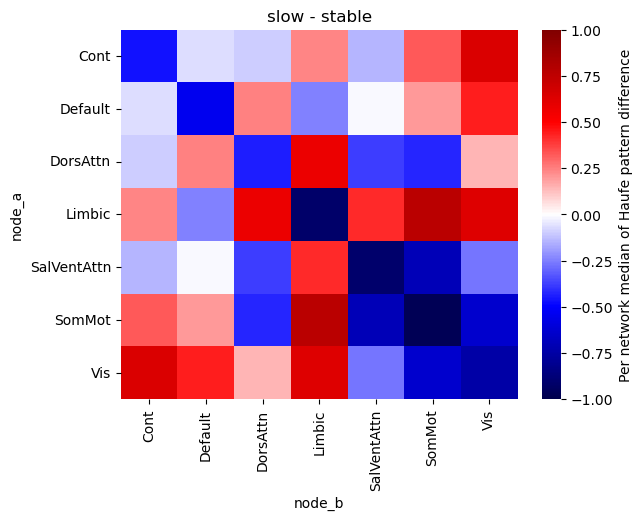

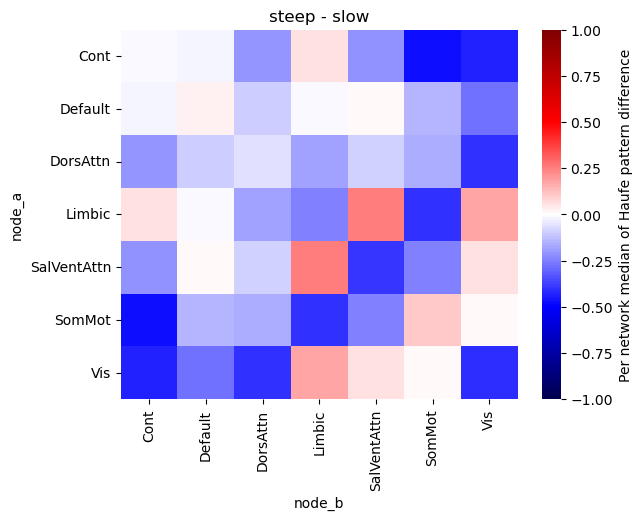

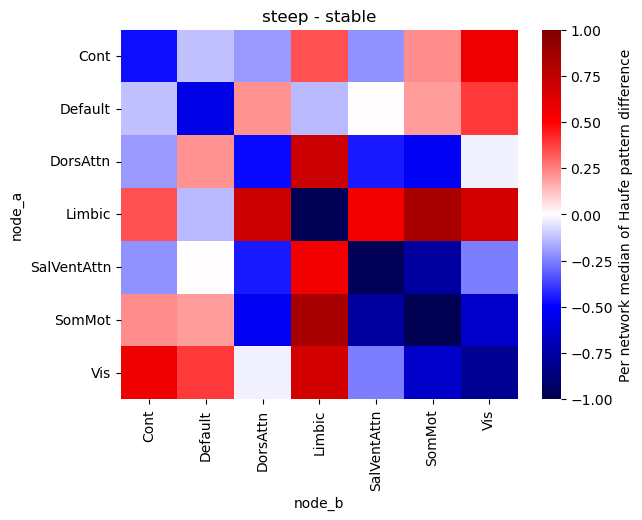

In [49]:
from bold_dementia.cogpred import MatrixResult

def relative_edge_count(blck):
    npos = np.sum((blck > 0))
    nneg = np.sum((blck < 0))
    return ((npos - nneg) / blck.size,)

def block_median(blck):
    return (np.median(blck),)

mr = MatrixResult(diffmaps, atlas)
for diffname, matrix in zip(diffnames, mr.get_macro_matrices(relative_edge_count)):
    sns.heatmap(
        matrix,
        cmap="seismic",
        #vmin=bounds[0],
        #vmax=bounds[1],
        vmin=-1,
        vmax=1,
        cbar_kws={"label": "Per network median of Haufe pattern difference"}
    )
    plt.title(diffname)
    plt.show()



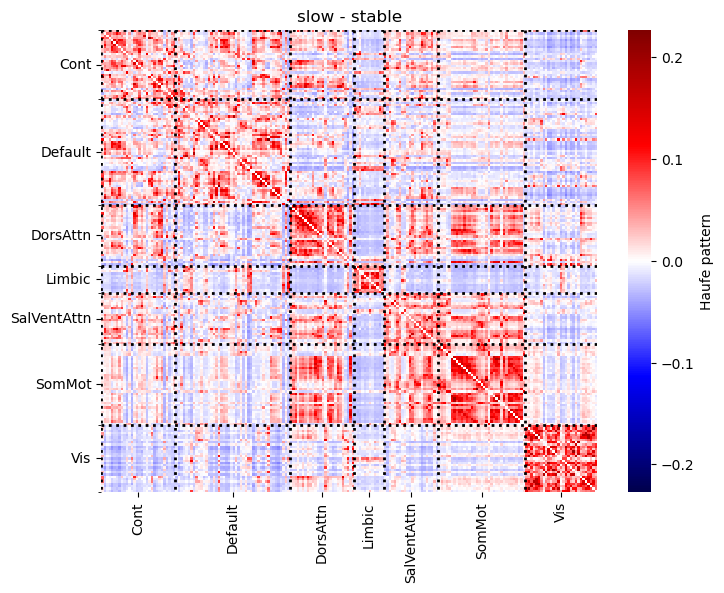

In [47]:
decline_vs_stable = slow_patterns
plot_matrix(decline_vs_stable, atlas, cmap="seismic", cbar_kws=dict(label="Haufe pattern"))
plt.title("slow - stable")
plt.show()